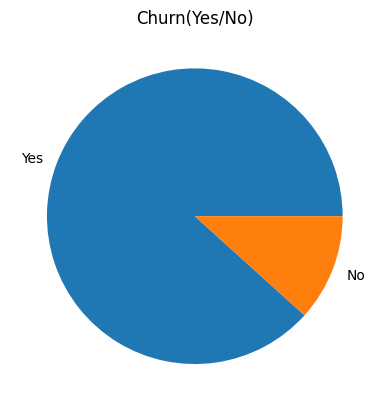

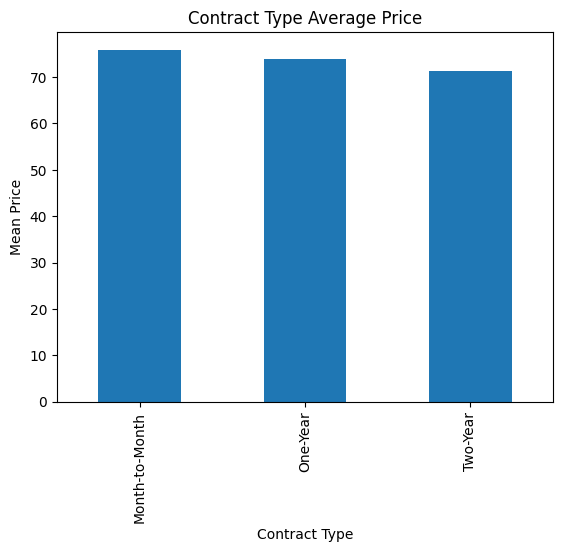

Accuracy: 0.93
ROC-AUC: 0.9923851633505281
Confusion matrix:
 [[ 23   0]
 [ 14 163]]


['model.pkl']

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import kagglehub
import pandas as pd
import matplotlib.pyplot as plt



df = pd.read_csv("customer_churn_data.csv")
############################## DATA ANALYSIS ####################################
df.head()

df.info()
df.isna().sum() #getting general info on dataset and realizing that internet service columns has nearly 300 null values


#replacing null values with empty string
df["InternetService"] =  df["InternetService"].fillna("")


#checking for duplicate values
df.duplicated().sum()


#checking to see any correlations with numerical data columns although this doesnt seem to provide any useful insight
numeric_columns_data = df.select_dtypes( include = ["number"])
numeric_columns_data.corr()


#Basic visualization on churn count
df["Churn"].value_counts().plot(kind = 'pie')
plt.title("Churn(Yes/No)")
plt.ylabel("")
plt.show()

#Looking for connections between churn and different columns 

df.groupby("Churn")["MonthlyCharges"].mean()
df.groupby(["Churn", "Gender"])["MonthlyCharges"].mean()

df.groupby("Churn")["Tenure"].mean()
df.groupby("Churn")["Age"].mean()

#A plot that shows longer contracts reduce monthly charges which can be exepected
df.groupby("ContractType")["MonthlyCharges"].mean().plot(kind = 'bar')
plt.ylabel("Mean Price")
plt.xlabel("Contract Type")
plt.title("Contract Type Average Price")
plt.show()

##################### FEATURE ENGINEERING ########################
import numpy as np, joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

#Cleaning columns to avoid typos/errors

df.columns = (df.columns.str.strip()
              .str.replace(r'[\s/]+','_', regex=True)
              .str.replace('[^0-9a-zA-Z_]', '', regex=True)
              .str.lower())

#Converting the target variable column from categorical data to numerical data 

y = df['churn'].astype(str).str.lower().map({'yes':1,'no':0,'1':1,'0':0}).astype(int)

#Using all other columns to predict churn 
X = df.drop(columns=['churn'])

#Using train test split (80%/20%) i.e training 80% of the data to compare with 20% test data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, #Here is used stratify to ensure the train test split of data is consistent with the acutal split of churn/not churn (83%/17%)
                                                    #I also set random state = 42 to freeze randomness to ensure consistent accuracy
    
)

# Separating both numeric and categorical data as they will need different preprocessing 
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

#I used the Standard Scaler method to re-centre the numeric  data so mean = 0 and S.D = 1 to stop larger columns dominating e.g.Monthly Charges over tenure
#I used OneHotEncoder to convert categorical data into numeric binary columns 
pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

#Using Logistic Regression with preprocessed data to predict churn column
pipe = Pipeline([
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced')) #I used max iteration = 1000 to give algorithm more room to converge 
])

#calling fit method to transform X_train with the preprocessing above and passing it through the Logistic Regression algorithm 
pipe.fit(X_train, y_train)

#Getting a vector of churn probabilities for each test sample 
proba = pipe.predict_proba(X_test)[:,1]

#If probability >= 0.5 it predicts churn else not churn 
preds = (proba >= 0.5).astype(int)



print("Accuracy:", accuracy_score(y_test, preds)) #Gives proportion of correct predictions 
print("ROC-AUC:", roc_auc_score(y_test, proba)) #Measures how well the model separates classes across all thresholds

#Confusion matrix gives us true negatives, false positives, false negatives, true positives 
print("Confusion matrix:\n", confusion_matrix(y_test, preds))

#Later you I load it and instantly reuse the trained pipeline on new data.
joblib.dump(pipe, "model.pkl")

